In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad

from numba import jit, njit, int64, float64, boolean, types, cfunc
import numba as nb
from numba_i0_i1 import i0, i1
# from numbalsoda import lsoda_sig, lsoda 

from handle_collisions import handle_collisions

import matplotlib.pyplot as plt
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=18)


from joblib import Parallel, delayed
e = 1.602e-19
eps0 = 8.8541878128e-12
u = 1.66e-27
k_B = 1.381e-23 # J/K
Omega = 2*np.pi*305e3

In [2]:
import sys
# sys.path.append('C:\\Users\\au643642\\OneDrive - Aarhus universitet\\Dokumenter\\PhD\\LUNA2 Mass selection tool')
# from mass_selection_functions import popt_all_fit
# xi1, xi0, upper_edge_shrink1, upper_edge_shrink0, lower_edge_shrink1, lower_edge_shrink0 = popt_all_fit[:6]
# from mathieu_functions import upper_mathieu_variable_shrink, lower_mathieu_variable_shrink

def get_z0(r0, mz):
    xi = (xi1*mz + xi0)
    return np.sqrt((xi-r0**2)/2)

def QIT_diagram(RF_V, upper, mz, QIT_r0, QIT_z0):
    xi = (QIT_r0**2 + 2*QIT_z0**2)
    q_to_V = mz*u/e*Omega**2/8 * xi
    if upper:
        return upper_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V
    return lower_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V

In [3]:
c_sig = types.double(types.intc, types.CPointer(types.float64))
@cfunc(c_sig)
def E_field_x_integrand(n, args):
    ## Derivation from R. Wanzenberg. DESY Internal Report
    ## Transformed variables from q->q**4, dq->4q**3, for better convergence
    # Small epsilon allowed for regularization. But eps=0 often works
    q = args[0]
    x = args[1] 
    y = args[2] 
    z = args[3] 
    sigma_x = args[4] 
    sigma_y = args[5] 
    sigma_z = args[6] 
    eps = args[7]

    qx = q**4 + 2*sigma_x**2 + eps
    qy = q**4 + 2*sigma_y**2 + eps
    qz = q**4 + 2*sigma_z**2 + eps
    return 1/qx * np.exp(-x**2/qx - y**2/qy - z**2/qz) / np.sqrt(qx*qy*qz) * 4 *q**3

@cfunc(c_sig)
def E_field_y_integrand(n, args):
    ## Derivation from R. Wanzenberg. DESY Internal Report
    ## Transformed variables from q->q**4, dq->4q**3, for better convergence
    # Small epsilon allowed for regularization. But eps=0 often works
    q = args[0]
    x = args[1] 
    y = args[2] 
    z = args[3] 
    sigma_x = args[4] 
    sigma_y = args[5] 
    sigma_z = args[6] 
    eps = args[7]

    qx = q**4 + 2*sigma_x**2 + eps
    qy = q**4 + 2*sigma_y**2 + eps
    qz = q**4 + 2*sigma_z**2 + eps
    return 1/qy * np.exp(-x**2/qx - y**2/qy - z**2/qz) / np.sqrt(qx*qy*qz) * 4 *q**3

@cfunc(c_sig)
def E_field_z_integrand(n, args):
    ## Derivation from R. Wanzenberg. DESY Internal Report
    ## Transformed variables from q->q**4, dq->4q**3, for better convergence
    # Small epsilon allowed for regularization. But eps=0 often works
    q = args[0]
    x = args[1] 
    y = args[2] 
    z = args[3] 
    sigma_x = args[4] 
    sigma_y = args[5] 
    sigma_z = args[6] 
    eps = args[7]

    qx = q**4 + 2*sigma_x**2 + eps
    qy = q**4 + 2*sigma_y**2 + eps
    qz = q**4 + 2*sigma_z**2 + eps
    return 1/qz * np.exp(-x**2/qx - y**2/qy - z**2/qz) / np.sqrt(qx*qy*qz) * 4 *q**3
from scipy import LowLevelCallable
LLC_E_field_x_integrand = LowLevelCallable(E_field_x_integrand.ctypes)
LLC_E_field_y_integrand = LowLevelCallable(E_field_y_integrand.ctypes)
LLC_E_field_z_integrand = LowLevelCallable(E_field_z_integrand.ctypes)

In [4]:
@njit(nb.types.Tuple((float64[:], float64[:]))(float64, float64, float64))
def find_I0_lns(r0, z0, max_order):
    i = np.arange(max_order+1)
    ln = (2*i+1)*np.pi/2/z0
    res = i0(r0*ln)
    return res, ln
@njit(nb.types.Tuple((float64[:], float64[:]))(float64[:], float64[:], float64[:], float64[:]))
def optimized_besselsum(zs, rs, I0_lns, ln):
    cos_term = np.cos(np.outer(ln, zs))  # Precompute the cos term matrix
    sin_term = np.sin(np.outer(ln, zs))  # Precompute the sin term matrix
    r_ln_matrix = np.outer(ln, rs)
    i0_r_ln_matrix = i0(r_ln_matrix.flatten())
    i1_r_ln_matrix = i1(r_ln_matrix.flatten())
    i0_r_ln_matrix = i0_r_ln_matrix.reshape(r_ln_matrix.shape)
    i1_r_ln_matrix = i1_r_ln_matrix.reshape(r_ln_matrix.shape)
    
    bessel_r_matrix = (-1) ** np.arange(len(ln))[:, np.newaxis]       * i1_r_ln_matrix / I0_lns[:, np.newaxis]
    bessel_z_matrix = (-1) ** (np.arange(len(ln)) + 1)[:, np.newaxis] * i0_r_ln_matrix / I0_lns[:, np.newaxis]
    
    besselsum_r = np.sum(bessel_r_matrix * cos_term, axis=0)
    besselsum_z = np.sum(bessel_z_matrix * sin_term, axis=0)
    
    return besselsum_r, besselsum_z

def CIT_EOM_cartesian_w_SC(t, y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, 
                                               N_ions, sigmax_ions, sigmay_ions, sigmaz_ions, N_sim : int, is_not_out_of_bounds):
    q = charge_number*e

    xs = y[:N_sim]
    ys = y[N_sim:2*N_sim]
    rs = np.sqrt(xs**2 + ys**2)

    zs = y[2*N_sim:3*N_sim]
    
    vxs = y[3*N_sim:4*N_sim]
    vys = y[4*N_sim:5*N_sim]
    vzs = y[5*N_sim:]

    besselsum_r, besselsum_z = optimized_besselsum(zs, rs, I0_lns, ln)
    t_factor = -2*q/mass/z0 * (U + V*np.cos(Omega*t))


    Ix = np.array([quad(LLC_E_field_x_integrand, 0, 100*(sigmax_ions+sigmay_ions+sigmaz_ions), 
                args=(x, y, z, sigmax_ions, sigmay_ions, sigmaz_ions, 0))[0]
                for x, y, z in zip(xs, ys, zs)])
    Iy = np.array([quad(LLC_E_field_y_integrand, 0, 100*(sigmax_ions+sigmay_ions+sigmaz_ions), 
                args=(x, y, z, sigmax_ions, sigmay_ions, sigmaz_ions, 0))[0]
                for x, y, z in zip(xs, ys, zs)])
    Iz = np.array([quad(LLC_E_field_z_integrand, 0, 100*(sigmax_ions+sigmay_ions+sigmaz_ions), 
                args=(x, y, z, sigmax_ions, sigmay_ions, sigmaz_ions, 0))[0]
                for x, y, z in zip(xs, ys, zs)])
    
    sqrt_pi = 1.77245385091

    space_charge_field_x = N_ions*(e*charge_number)/(4*np.pi*eps0) * 2 * xs / sqrt_pi * Ix
    space_charge_field_y = N_ions*(e*charge_number)/(4*np.pi*eps0) * 2 * ys / sqrt_pi * Iy
    space_charge_field_z = N_ions*(e*charge_number)/(4*np.pi*eps0) * 2 * zs / sqrt_pi * Iz


    acc_r = besselsum_r * t_factor
    acc_z = besselsum_z * t_factor

    ret = np.empty_like(y)
    ret[       :  N_sim] = is_not_out_of_bounds * vxs
    ret[  N_sim:2*N_sim] = is_not_out_of_bounds * vys
    ret[2*N_sim:3*N_sim] = is_not_out_of_bounds * vzs

    ret[3*N_sim:4*N_sim] = is_not_out_of_bounds * (acc_r * xs / rs + q/mass * space_charge_field_x)
    ret[4*N_sim:5*N_sim] = is_not_out_of_bounds * (acc_r * ys / rs + q/mass * space_charge_field_y)
    ret[5*N_sim:       ] = is_not_out_of_bounds * (acc_z           + q/mass * space_charge_field_z)  
    return ret

In [23]:
# @njit
def simulate_CIT_with_buffer_gas(U : float, V : float, r0 : float, z0 : float, Omega : float,
                                 mass_amu : int, charge_number : int, N_ions, N_sim : int, sigma_xyz : float,
                                 T : float, ts):
    mass = mass_amu * u
    mass_gas = 4 * u
    reduced_mass = mass*mass_gas/(mass + mass_gas)
    
    buffer_gas_n_density = 7.23e21 / 3
    cross_section_ion_buffer_gas = 2.3e-18*10

    N_order = 10
    I0_lns, ln = find_I0_lns(r0, z0, N_order)
    
    MB_sigma = np.sqrt(k_B*T / mass)
    y0s = np.empty(6*N_sim)
    for i in range(3*N_sim):
        y0s[i]         = np.random.normal(0, sigma_xyz)
        y0s[3*N_sim+i] = np.random.normal(0, MB_sigma)

    y0s[:3*N_sim] = np.clip(y0s[:3*N_sim], -3*sigma_xyz, 3*sigma_xyz)
    y0s[3*N_sim:] = np.clip(y0s[3*N_sim:], -3*MB_sigma, 3*MB_sigma)

    curr_y = y0s
    curr_sigmax = sigma_xyz
    curr_sigmay = sigma_xyz
    curr_sigmaz = sigma_xyz

    xs = curr_y[:N_sim]
    ys = curr_y[N_sim:2*N_sim]
    zs = curr_y[2*N_sim:3*N_sim]
    vxs = curr_y[3*N_sim:4*N_sim]
    vys = curr_y[4*N_sim:5*N_sim]
    vzs = curr_y[5*N_sim:]

    axs = np.zeros(N_sim)
    ays = np.zeros(N_sim)
    azs = np.zeros(N_sim)

    out_of_bounds = np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0)
    not_out_of_bounds = np.logical_not(out_of_bounds)
    curr_N = N_sim
    
    n_steps = len(ts)-1
    N_history = np.zeros(n_steps)
    n_collisions_history = np.zeros(n_steps)
    vs_mean_history = np.empty(n_steps)#[np.array([np.mean(vxs), np.mean(vys), np.mean(vzs)])]
    vs_std_history  = np.empty(n_steps)#[np.array([np.std(vxs), np.std(vys), np.std(vzs)])]
    r_sigma_history = np.zeros(n_steps)
    z_sigma_history = np.zeros(n_steps)
    for i in range(n_steps):
        t_start = ts[i]
        t_end = ts[i+1]
        t_step = t_end - t_start

        ## -- Velocity-Verlet
        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]
        vxs = curr_y[3*N_sim:4*N_sim]
        vys = curr_y[4*N_sim:5*N_sim]
        vzs = curr_y[5*N_sim:]

        # Update positions
        xs += vxs*t_step + 0.5*axs*t_step**2
        ys += vys*t_step + 0.5*ays*t_step**2
        zs += vzs*t_step + 0.5*azs*t_step**2

        # Calculate the acceleration
        dy = CIT_EOM_cartesian_w_SC(t_start, curr_y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln,\
                                               N_ions * curr_N / N_sim, curr_sigmax, curr_sigmay, curr_sigmaz, N_sim, not_out_of_bounds)
 
        # Update velocities
        curr_y[3*N_sim:4*N_sim] += 0.5 * (axs + dy[3*N_sim:4*N_sim]) * t_step
        curr_y[4*N_sim:5*N_sim] += 0.5 * (ays + dy[4*N_sim:5*N_sim]) * t_step
        curr_y[5*N_sim:]        += 0.5 * (azs + dy[5*N_sim:]       ) * t_step

        # Update accelerations
        axs = dy[3*N_sim:4*N_sim]
        ays = dy[4*N_sim:5*N_sim]
        azs = dy[5*N_sim:]
        ## - END VELOCITY-VERLET


        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]
        vxs = curr_y[3*N_sim:4*N_sim]
        vys = curr_y[4*N_sim:5*N_sim]
        vzs = curr_y[5*N_sim:]

        # Check if some of the simulation ions are out of bounds
        out_of_bounds     = np.logical_or(out_of_bounds, np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0))
        not_out_of_bounds = np.logical_not(out_of_bounds)

        curr_N = np.sum(not_out_of_bounds)
        N_history[i] = curr_N
        if curr_N < 10:
            break

        ## Handle collisions - update velocities
        ## Calculate probability of collision - Ding 2002
        delta_vxs, delta_vys, delta_vzs, n_collisions = handle_collisions(vxs, vys, vzs, N_sim, t_step, not_out_of_bounds, T, mass, 
                                                                          mass_gas, reduced_mass, buffer_gas_n_density, cross_section_ion_buffer_gas)
        
        n_collisions_history[i] = n_collisions
        vxs += delta_vxs
        vys += delta_vys
        vzs += delta_vzs

        ## Update cloud sigma
        curr_sigmax = np.std(np.sort(xs[not_out_of_bounds])[:N_sim-5])
        curr_sigmay = np.std(np.sort(ys[not_out_of_bounds])[:N_sim-5])
        curr_sigmaz = np.std(np.sort(zs[not_out_of_bounds])[:N_sim-5])        

        r_sigma_history[i] = np.std(np.sqrt(np.sort(xs[not_out_of_bounds])[:N_sim-5]**2 + np.sort(ys[not_out_of_bounds])[:N_sim-5]**2))
        z_sigma_history[i] = curr_sigmaz

        # print('Progress: {:2.2f}%'.format((i + 1)/len(ts) * 100), end='\r')
    return curr_N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history,\
            r_sigma_history, z_sigma_history

In [29]:
mass = 443
charge_number = 1
N_sim = 100
N_ions = 5e4

delta_t = 1e-3
ts = np.arange(0, delta_t, 5e-8)
r0 = 10e-3
z0 = 9e-3
sigma_xyz = 6e-3
T = 300

N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history,\
r_sigma_history, z_sigma_history\
   = simulate_CIT_with_buffer_gas(U=0, V=300, r0=r0, z0=z0, Omega = Omega,
                                    mass_amu=mass, charge_number=charge_number, 
                                    N_ions=N_ions, N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                    ts=ts)

C:\Users\lenle\AppData\Local\Temp\ipykernel_33104\4233598057.py:68: RuntimeWarning: invalid value encountered in multiply
  ret[3*N_sim:4*N_sim] = is_not_out_of_bounds * (acc_r * xs / rs + q/mass * space_charge_field_x)
C:\Users\lenle\AppData\Local\Temp\ipykernel_33104\4233598057.py:69: RuntimeWarning: invalid value encountered in multiply
  ret[4*N_sim:5*N_sim] = is_not_out_of_bounds * (acc_r * ys / rs + q/mass * space_charge_field_y)
C:\Users\lenle\AppData\Local\Temp\ipykernel_33104\4233598057.py:70: RuntimeWarning: invalid value encountered in multiply
  ret[5*N_sim:       ] = is_not_out_of_bounds * (acc_z           + q/mass * space_charge_field_z)
C:\Users\lenle\AppData\Local\Temp\ipykernel_33104\4233598057.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Ix = np.array([quad(LLC_E_field_x_integrand, 0, 100*(sigmax_ions+sigmay_ions+sigmaz_ions),
C:\Users\lenl

Text(0, 0.5, 'Number of ions in trap')

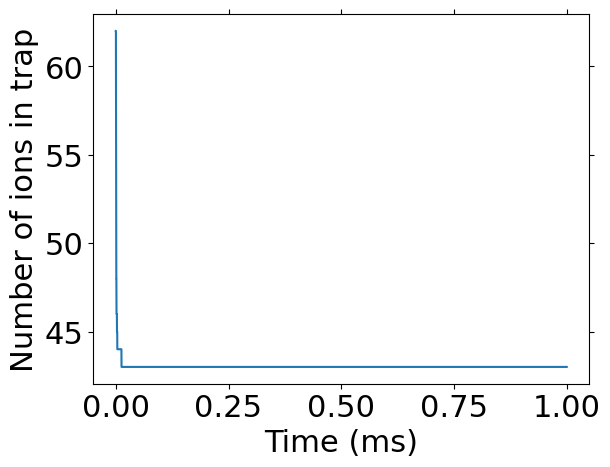

In [30]:
plt.plot(ts[:-1]*1e3, N_history)
plt.xlabel('Time (ms)')
plt.ylabel('Number of ions in trap')

0.433837845190611 0.14276786915423675


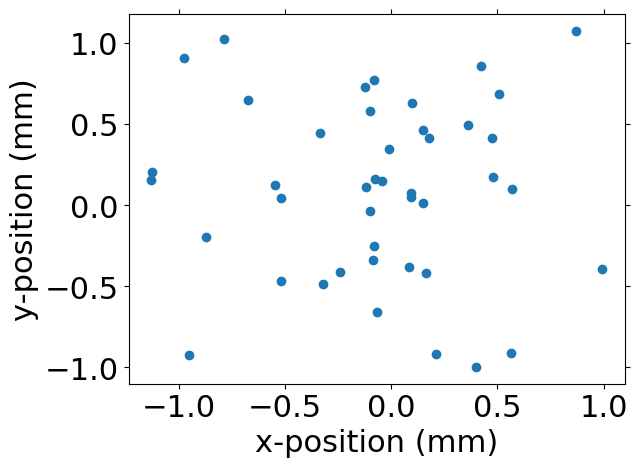

In [31]:
xs = curr_y[:N_sim]
ys = curr_y[N_sim:2*N_sim]
zs = curr_y[2*N_sim:3*N_sim]
rs = np.sqrt(xs**2 + ys**2)
plt.scatter(xs[not_out_of_bounds]*1e3, ys[not_out_of_bounds]*1e3)
# plt.xlim(-z0*1e3, z0*1e3)
# plt.ylim(0, r0*1e3)
# plt.xlim(-1, 1)
# plt.ylim(0, 1)
plt.xlabel('x-position (mm)')
plt.ylabel('y-position (mm)')

print(r_sigma_history[-1]*1e3, z_sigma_history[-1]*1e3)

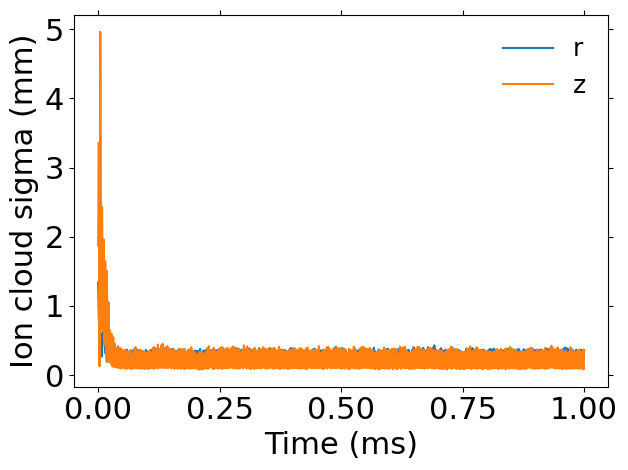

In [16]:
plt.plot(ts[:-1]*1e3, r_sigma_history*1e3, label='r')
plt.plot(ts[:-1]*1e3, z_sigma_history*1e3, label='z')
# plt.xlim(0, 0.1)
# plt.ylim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Ion cloud sigma (mm)')
plt.legend(frameon=False)
plt.tight_layout()

In [ ]:
VDCs = np.linspace(-50,120,5)
VRFs = np.linspace(250,500,5)

def get_stability(RF):
    mass = 443
    charge_number = 1
    N_sim = 100

    delta_t = 1e-3
    ts = np.arange(0, delta_t, 5e-8)
    r0 = 10e-3
    z0 = 9e-3
    sigma_xyz = 1e-3
    T = 300
    N_arr = []
    for DC in VDCs:
        N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history\
        = simulate_CIT_with_buffer_gas(U=DC, V=RF, r0=r0, z0=z0, Omega = Omega,
                                    mass_amu=mass, charge_number=charge_number, 
                                    N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                    ts=ts)
        N_arr.append(N)
    return N_arr
U_edge_long_sim = Parallel(n_jobs=14, verbose=12)(delayed(get_stability)(RF) for RF in VRFs)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Batch computation too fast (0.0725s.) Setting batch_size=2.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=14)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


PicklingError: Could not pickle the task to send it to the workers.

In [16]:
def get_us(V):
    xi = np.sqrt(2.35e-4)
    U_range = 10
    delta_U = 0.5

    edge_upper = np.round(QIT_diagram(V, True,  mass, QIT_r0=xi, QIT_z0=0)[0], decimals=1)
    edge_lower = np.round(QIT_diagram(V, False, mass, QIT_r0=xi, QIT_z0=0)[0], decimals=1)
    Us = np.empty(1)
    if edge_lower - edge_upper < U_range*2:
        Us = np.arange(edge_upper - U_range, edge_lower + U_range, delta_U)
    else: 
        Us = np.concatenate((np.arange(edge_upper-U_range, edge_upper+U_range, delta_U),
                             np.arange(edge_lower-U_range, edge_lower+U_range, delta_U )))
    return Us, len(Us)
get_us(300)

(array([-34. , -33.5, -33. , -32.5, -32. , -31.5, -31. , -30.5, -30. ,
        -29.5, -29. , -28.5, -28. , -27.5, -27. , -26.5, -26. , -25.5,
        -25. , -24.5, -24. , -23.5, -23. , -22.5, -22. , -21.5, -21. ,
        -20.5, -20. , -19.5, -19. , -18.5, -18. , -17.5, -17. , -16.5,
        -16. , -15.5, -15. , -14.5,  36.6,  37.1,  37.6,  38.1,  38.6,
         39.1,  39.6,  40.1,  40.6,  41.1,  41.6,  42.1,  42.6,  43.1,
         43.6,  44.1,  44.6,  45.1,  45.6,  46.1,  46.6,  47.1,  47.6,
         48.1,  48.6,  49.1,  49.6,  50.1,  50.6,  51.1,  51.6,  52.1,
         52.6,  53.1,  53.6,  54.1,  54.6,  55.1,  55.6,  56.1]),
 80)

In [10]:
def simulate_signal(V, r0, z0, Omega, mass, charge_number, N_ions, N_sim, T, ts):
    xi = np.sqrt(2.35e-4)
    edge_upper = QIT_diagram(V, True,  mass, QIT_r0=xi, QIT_z0=0)[0]
    edge_lower = QIT_diagram(V, False, mass, QIT_r0=xi, QIT_z0=0)[0]
    delta_U_V = 10
    U_edge_steps = 20
    Us = np.empty(U_edge_steps*2)
    if edge_lower - edge_upper < delta_U_V*2:
        Us = np.linspace(edge_upper - delta_U_V, edge_lower + delta_U_V, U_edge_steps*2)
    else: 
        Us = np.concatenate((np.linspace(edge_upper-delta_U_V, edge_upper+delta_U_V),
                            np.linspace(edge_lower-delta_U_V, edge_lower+delta_U_V)))
    Ns = []
    N_histories = []
    for U in Us:
        N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history,\
        r_sigma_history, z_sigma_history\
        = simulate_CIT_with_buffer_gas(U=U, V=V, r0=r0, z0=z0, Omega = Omega,
                                            mass_amu=mass, charge_number=charge_number, 
                                            N_ions=N_ions, N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                            ts=ts)
        Ns.append(N)
        N_histories.append(N_history)
    return np.array(Ns), Us, np.array(N_histories)

In [14]:
N_sim = 100

mass = 414
charge_number = 1
N_sim = 100
N_ions = 1e4

delta_t = 10e-3
ts = np.arange(0, delta_t, 50e-9)
r0 = 10e-3
z0 = 9e-3
sigma_xyz = 0.25e-3
T = 100

# Vs = np.linspace(200, 500, 30)
Vs = np.linspace(300, 450, 15)

Ns, Us, N_histories = zip(*Parallel(n_jobs=15, verbose=11)(delayed(simulate_signal)(V, r0, z0, Omega, mass, charge_number, N_ions, N_sim, T, ts) for V in Vs))
Ns = np.array(Ns)
Us = np.array(Us)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Batch computation too fast (0.1585s.) Setting batch_size=2.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    0.1s remaining:    1.0s
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=15)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
# Define the function to simulate the signal
def simulate_signal_wrapper(args):
    return simulate_signal(*args)

# Prepare arguments for the simulation
simulation_args = [(V, r0, z0, Omega, mass, charge_number, N_ions, N_sim, T, ts) for V in Vs]

# Create a Pool for multiprocessing
with Pool(processes=15) as pool:
    results = pool.map(simulate_signal_wrapper, simulation_args)

# Unpack the results
Ns, Us, N_histories = zip(*results)

In [ ]:
np.savez('CIT_SC_edge_10ms_50ns_100K_init_0.25mm', Vs=Vs, Us=Us, Ns=Ns, N_histories=N_histories, allow_pickle=True)

In [16]:
np.savez('CIT_edge_10ms_50ns_100K_0.25mm_2', Vs=Vs, Us=Us, Ns=Ns, N_histories=N_histories, allow_pickle=True)

In [4]:
load_file = np.load('CIT_edge_10ms_50ns_100K_0.25mm_2.npz')
Vs = load_file['Vs']
Us = load_file['Us']
Ns = load_file['Ns']

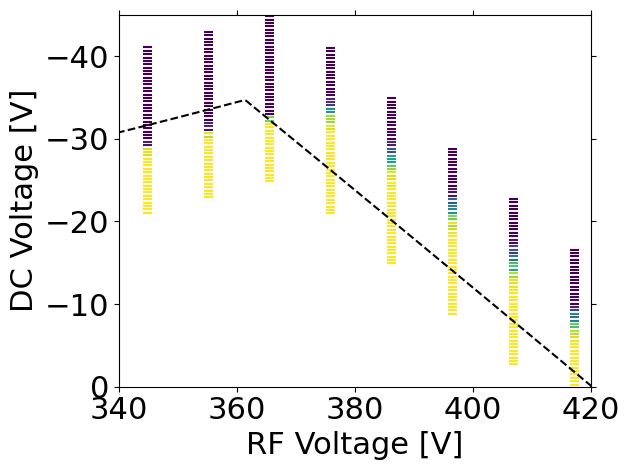

In [9]:
for V, U, N in zip(Vs, Us, Ns):
    n = len(N)
    plt.scatter(V*np.ones(n), U, c=N, marker='_')
mass = 414
linspace_Vs = np.linspace(Vs[0], Vs[-1], 1000)
xi = np.sqrt(2.35e-4)
plt.plot(linspace_Vs, QIT_diagram(linspace_Vs, True,  mass, QIT_r0=xi, QIT_z0=0), 'k--')
plt.plot(linspace_Vs, QIT_diagram(linspace_Vs, False, mass, QIT_r0=xi, QIT_z0=0), 'k--')

plt.xlim(340, 420)
plt.ylim(0, -45)
plt.xlabel('RF Voltage [V]')
plt.ylabel('DC Voltage [V]')
plt.tight_layout()

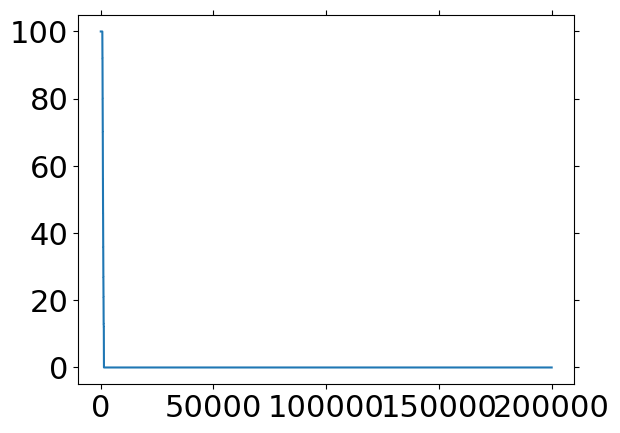

In [29]:
load_file = np.load('C:\\Users\\au643642\\OneDrive - Aarhus universitet\\Dokumenter\\PhD\\LUNA2 new trap sim\\Small ion cloud + collisions\\sim data\\CIT_SC_U_-27.00_V_300.00.npz')
plt.plot(load_file['N_history'])
# plt.xlim(0, 1000)